In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import json
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

train_dir = '/Users/cata/Desktop/proj-ML/asl_alphabet_train'  
test_dir = '/Users/cata/Desktop/proj-ML/asl_alphabet_test'   

train_classes = os.listdir(train_dir)
print(f"Training classes: {train_classes}")

test_classes = os.listdir(test_dir)
print(f"Testing classes: {test_classes}")


Training classes: ['.DS_Store', 'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W']
Testing classes: ['F_test.jpg', 'G_test.jpg', 'L_test.jpg', 'M_test.jpg', 'R_test.jpg', 'S_test.jpg', 'X_test.jpg', 'Y_test.jpg', 'U_test.jpg', 'T_test.jpg', 'A_test.jpg', 'K_test.jpg', 'J_test.jpg', 'Z_test.jpg', 'nothing_test.jpg', 'Q_test.jpg', 'P_test.jpg', 'space_test.jpg', 'O_test.jpg', 'N_test.jpg', 'E_test.jpg', 'D_test.jpg', 'H_test.jpg', 'I_test.jpg', 'B_test.jpg', 'C_test.jpg', 'V_test.jpg', 'W_test.jpg']


## Visualizing a Sample Grid of Images from a Dataset


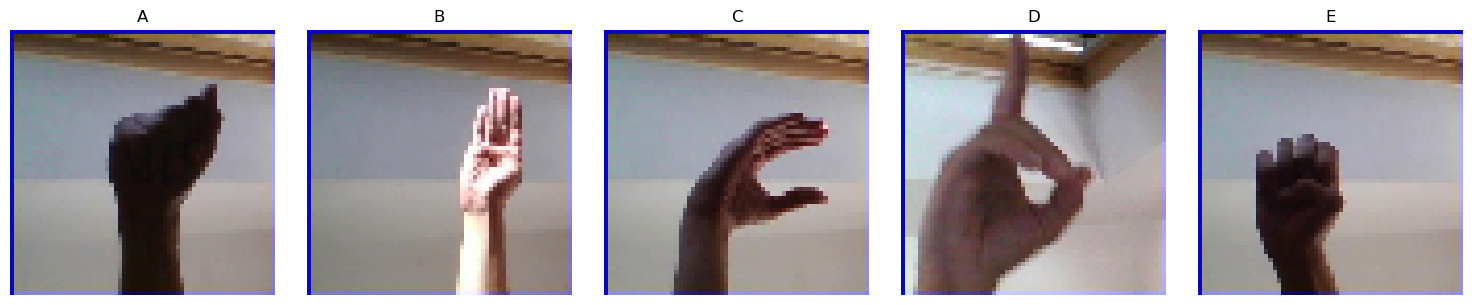

In [2]:


def plot_images_in_grid(image_paths, titles, rows=1, cols=5, figsize=(15,3)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

    for img_path, title, ax in zip(image_paths, titles, axes):
        img = image.load_img(img_path, target_size=(64, 64))
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

train_data_dir = '/Users/cata/Desktop/proj-ML/asl_alphabet_train'  

sample_image_paths = []
titles = []
for class_name in sorted(os.listdir(train_data_dir)):
    if class_name == '.DS_Store':
        continue  #skip this file (default macOS file that doesnt contain images for training/testing)
    class_folder = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_folder):  #check if it's a dir
        files = os.listdir(class_folder)
        if files:  #check if the dir is not empty
            sample_image = files[0]  #take the first image in the folder
            sample_image_paths.append(os.path.join(class_folder, sample_image))
            titles.append(class_name)

    if len(sample_image_paths) == 5:  #display 5 images 
        break

plot_images_in_grid(sample_image_paths, titles)


## Class Distribution in the Training Dataset

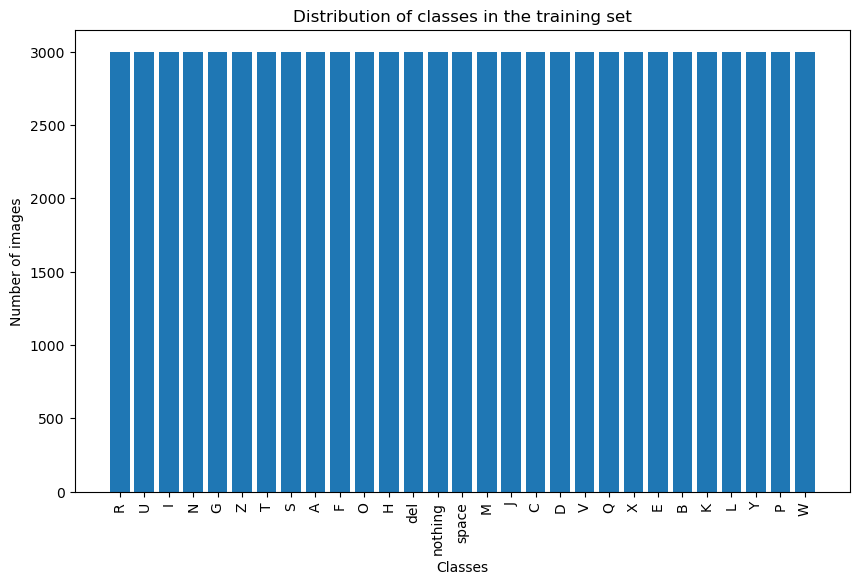

In [3]:
class_distribution = {cls: len(os.listdir(os.path.join(train_data_dir, cls)))
                      for cls in os.listdir(train_data_dir)
                      if os.path.isdir(os.path.join(train_data_dir, cls)) and cls != '.DS_Store'}

sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10,6))
plt.bar(sorted_class_distribution.keys(), sorted_class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Distribution of classes in the training set')
plt.xticks(rotation=90)  #rotate class names to be readable
plt.show()


## Setting Up Data Generators for Model Training and Evaluation

In [4]:

IMAGE_SIZE = (64, 64)  # resized
BATCH_SIZE = 32  

#training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # using 10% of the data as validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

#connect data generators to dataset folders
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  #set as training data
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  #set as validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  #important for evaluation, to not shuffle the data
)



Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 0 images belonging to 0 classes.


## Constructing and Compiling a CNN for Image Classification

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), #32 filters, kernel size 3
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'), #layer 2
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'), #layer 3
    MaxPooling2D(2, 2),
    
    Flatten(),
    
    Dense(512, activation='relu'), #hidden layer
    
    Dropout(0.5),
    
    Dense(29, activation='softmax') #output layer with 29 neurons, one for each class (letter/symbol)
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy']
)

model.summary()

/Users/cata/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,467,933 (9.41 MB)

 Trainable params: 2,467,933 (9.41 MB)

 Non-trainable params: 0 (0.00 B)

## Implementing Custom Callbacks for Dynamic Learning Rate Adjustment and Model Checkpointing


In [8]:

class DynamicLearningRate(Callback):
    def on_epoch_end(self, epoch, logs=None):
        new_lr = 0.001 * (0.1 ** (epoch // 10))
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
        print(f"\nEpoch: {epoch+1}, Learning Rate changed to: {new_lr}")

#dynamic_lr = DynamicLearningRate() #callback instance
#early_stopping = EarlyStopping(,monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('my_model.keras', monitor='val_accuracy', save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

## TRAINING MODEL

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=5,  # how many times the model goes through training data
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE,
    callbacks=[model_checkpoint]  
)

Epoch 1/5


/Users/cata/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2446/2446 ━━━━━━━━━━━━━━━━━━━━ 272s 111ms/step - accuracy: 0.4082 - loss: 1.9667 - val_accuracy: 0.7309 - val_loss: 0.7919
Epoch 2/5
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 0s 33us/step - accuracy: 0.8438 - loss: 0.4044 - val_accuracy: 0.8214 - val_loss: 0.5681
Epoch 3/5


2024-04-25 16:50:56.050083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/cata/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-25 16:50:56.078064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2446/2446 ━━━━━━━━━━━━━━━━━━━━ 276s 113ms/step - accuracy: 0.8873 - loss: 0.3318 - val_accuracy: 0.8244 - val_loss: 0.5192
Epoch 4/5
2446/2446 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.8438 - loss: 0.4461 - val_accuracy: 0.8214 - val_loss: 0.5002
Epoch 5/5


2024-04-25 16:55:32.382681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-25 16:55:32.405565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2446/2446 ━━━━━━━━━━━━━━━━━━━━ 293s 120ms/step - accuracy: 0.9341 - loss: 0.1900 - val_accuracy: 0.8198 - val_loss: 0.5703


## TRAINING & VALIDATION ACCURACY + LOSS

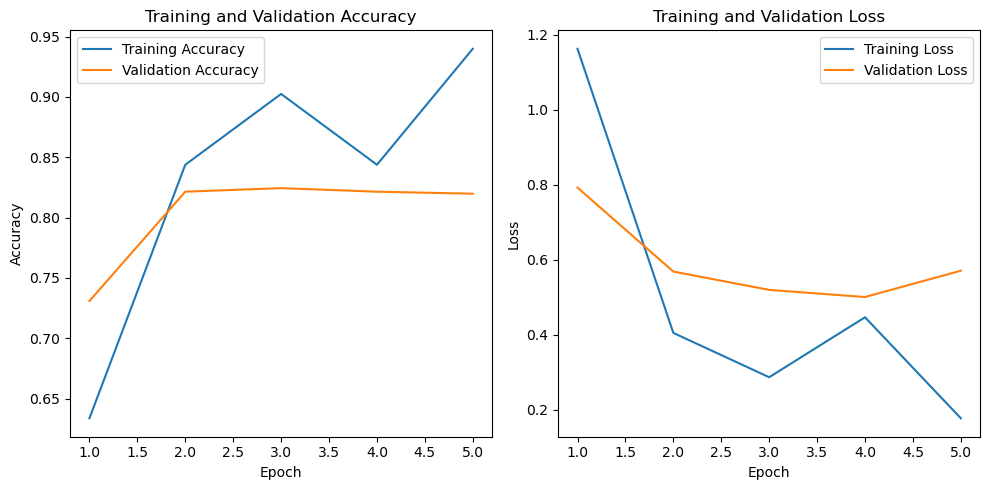

In [15]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## SAVE MODEL

In [10]:
model.save('my_model.keras')

## PREDICTIONS

In [11]:
model = load_model('my_model.keras') 

test_images = [img for img in os.listdir(test_dir) if img.lower().endswith('.jpg')]
label_map = {v: k for k, v in train_generator.class_indices.items()}

predictions = {}

for test_img in test_images:
    img_path = os.path.join(test_dir, test_img)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  #make it a batch of 1
    img_array /= 255.0  #normalize image array

    predicted_batch = model.predict(img_array)
    predicted_class = np.argmax(predicted_batch, axis=1)
    
    predicted_label = label_map[predicted_class[0]]
    
    predictions[test_img] = predicted_label

for filename, predicted_label in predictions.items():
    print(f"Image: {filename}, Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

## MODEL PERFORMANCE

In [25]:
correct_predictions = 0
total_predictions = len(test_images)
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_labels = []

for test_img, predicted_label in predictions.items():
    true_label = test_img.split('_')[0].upper()
    if true_label == predicted_label:
        correct_predictions += 1
        correct_images.append(test_img)  # Append the correct image path
        correct_labels.append(true_label)  # Append the true label
    else:
        incorrect_images.append(test_img)  # Append the incorrect image path
        incorrect_labels.append(true_label)  # Append the true label

accuracy = correct_predictions / total_predictions * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 89.29%


## VISUALISE PREDICTIONS

Correct Predictions:


FileNotFoundError: [Errno 2] No such file or directory: 'F_test.jpg'

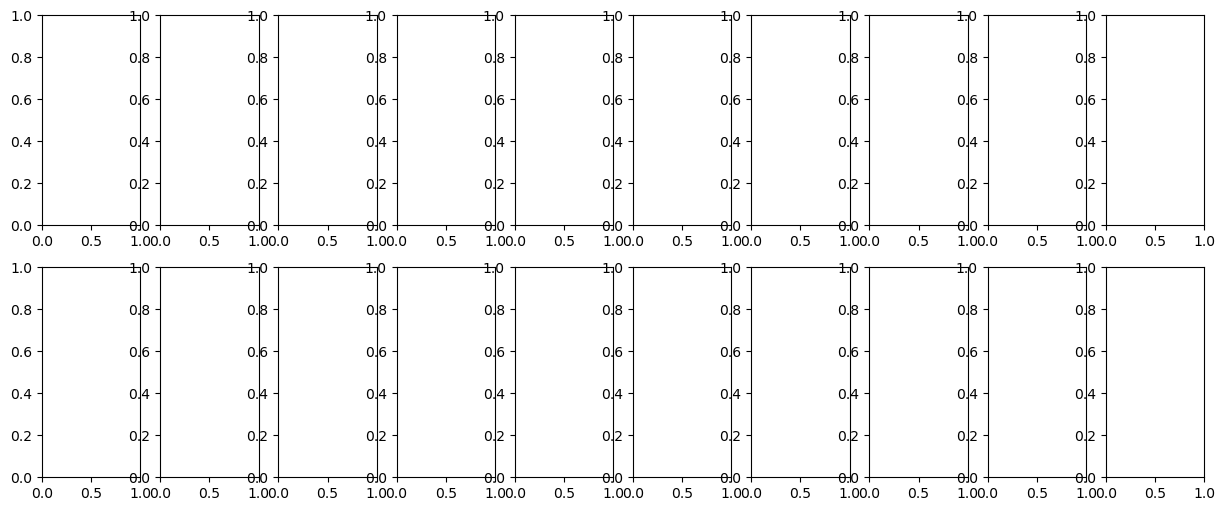

In [34]:
def visualize_predictions(image_paths, true_labels, predicted_labels):
    num_images = min(len(image_paths), 10)
    num_rows = (num_images + 4) // 5  # +4 for integer division adjustment

    fig, axes = plt.subplots(num_rows, max(5, num_images), figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 or num_images > 1 else [axes]  #ensure axes is always iterable

    for i in range(num_images):
        ax = axes[i]
        img = image.load_img(image_paths[i], target_size=IMAGE_SIZE)
        img = image.img_to_array(img).astype('uint8')
        ax.imshow(img)
        ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        ax.axis('off')
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


if correct_images:  
    print("Correct Predictions:")
    visualize_predictions(correct_images, correct_labels, correct_labels)

if incorrect_images:  
    print("Incorrect Predictions:")
    visualize_predictions(incorrect_images, incorrect_labels, incorrect_labels)



## SAVING LABEL MAPPING TO A JSON FILE

In [14]:

label_map = {v: k for k, v in train_generator.class_indices.items()}
with open('label_map.json', 'w') as f:
    json.dump(label_map, f)